In [1]:
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
RandomForestClassifier,
GradientBoostingClassifier,
ExtraTreesClassifier,
AdaBoostClassifier,
VotingClassifier
)
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except:
    HAS_XGB = False
    print("⚠️  XGBoost not installed")
try:
    from lightgbm import LGBMClassifier
    HAS_LGB = True
except:
    HAS_LGB = False
    print("⚠️  LightGBM not installed")
try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except:
    HAS_CAT = False
    print("⚠️  CatBoost not installed")
from sklearn.metrics import (
accuracy_score,
precision_score,
recall_score,
f1_score,
roc_auc_score,
confusion_matrix,
classification_report,
roc_curve
)
print("✅ All libraries imported")
print(f"   XGBoost: {'✅' if HAS_XGB else '❌'}")
print(f"   LightGBM: {'✅' if HAS_LGB else '❌'}")
print(f"   CatBoost: {'✅' if HAS_CAT else '❌'}")

✅ All libraries imported
   XGBoost: ✅
   LightGBM: ✅
   CatBoost: ✅


In [2]:
print("=" * 80)
print("LOADING PREPARED DATA")
print("=" * 80)

#Load data
X_train = pd.read_pickle('D:\cricket/X_train.pkl')
X_val = pd.read_pickle('D:\cricket/X_val.pkl')
X_test = pd.read_pickle('D:\cricket/X_test.pkl')
y_train = pd.read_pickle('D:\cricket/y_train.pkl')
y_val = pd.read_pickle('D:\cricket/y_val.pkl')
y_test = pd.read_pickle('D:\cricket/y_test.pkl')
print(f"\n✅ Data loaded:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"\n📊 Target distribution:")
print(f"   Train: Class 0={sum(y_train==0)}, Class 1={sum(y_train==1)} ({np.mean(y_train)*100:.1f}% positive)")
print(f"   Test:  Class 0={sum(y_test==0)}, Class 1={sum(y_test==1)} ({np.mean(y_test)*100:.1f}% positive)")

LOADING PREPARED DATA

✅ Data loaded:
   X_train: (2958, 34)
   X_val:   (634, 34)
   X_test:  (635, 34)

📊 Target distribution:
   Train: Class 0=1554, Class 1=1404 (47.5% positive)
   Test:  Class 0=352, Class 1=283 (44.6% positive)


In [3]:
print("=" * 80)
print("ANALYZING FEATURES")
print("=" * 80)

#Separate categorical and numerical
categorical_features = []
numerical_features = []
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        categorical_features.append(col)
    elif X_train[col].dtype in ['int64', 'float64']:
        n_unique = X_train[col].nunique()
        # If few unique values and small compared to dataset, treat as categorical
        if n_unique < 20 and n_unique < len(X_train) * 0.05:
            categorical_features.append(col)
        else:
            numerical_features.append(col)
print(f"\n📊 Feature types:")
print(f"   Categorical: {len(categorical_features)}")
for feat in categorical_features:
    print(f"      - {feat} ({X_train[feat].nunique()} unique values)")
print(f"\n   Numerical: {len(numerical_features)}")
for feat in numerical_features[:10]:
    print(f"      - {feat}")
if len(numerical_features) > 10:
    print(f"      ... and {len(numerical_features)-10} more")

ANALYZING FEATURES

📊 Feature types:
   Categorical: 21
      - venue (377 unique values)
      - city (201 unique values)
      - batting_team (101 unique values)
      - bowling_team (100 unique values)
      - team1 (100 unique values)
      - team2 (101 unique values)
      - toss_winner (101 unique values)
      - toss_decision (2 unique values)
      - innings (1 unique values)
      - over (1 unique values)
      - ball (1 unique values)
      - current_wickets (10 unique values)
      - wickets_remaining (10 unique values)
      - match_phase (1 unique values)
      - is_powerplay (1 unique values)
      - is_middle (1 unique values)
      - is_death (1 unique values)
      - toss_winner_batting (2 unique values)
      - toss_bat (2 unique values)
      - toss_field (2 unique values)
      - target (2 unique values)

   Numerical: 10
      - current_score
      - balls_bowled
      - balls_remaining
      - runs_last_5
      - runs_last_10
      - current_run_rate
      - run_r

In [4]:
print("=" * 80)
print("FEATURE ENGINEERING - REDUCE CARDINALITY")
print("=" * 80)

def get_top_categories(df, column, max_categories=20):
    return df[column].value_counts().head(max_categories).index.tolist()

def apply_reduction(df, column, top_categories):
    df[column + '_reduced'] = df[column].apply(
        lambda x: x if x in top_categories else 'Other'
    )
    return df

high_card_cols = [
    'venue', 'city', 'batting_team', 'bowling_team',
    'team1', 'team2', 'toss_winner'
]

top_cat_map = {}

for col in high_card_cols:
    top_cat_map[col] = get_top_categories(X_train, col)

    X_train = apply_reduction(X_train, col, top_cat_map[col])
    X_val   = apply_reduction(X_val, col, top_cat_map[col])
    X_test  = apply_reduction(X_test, col, top_cat_map[col])

    print(f"✅ Reduced {col}")

# Drop originals
X_train.drop(columns=high_card_cols, inplace=True)
X_val.drop(columns=high_card_cols, inplace=True)
X_test.drop(columns=high_card_cols, inplace=True)

print("✅ Cardinality reduction complete")


FEATURE ENGINEERING - REDUCE CARDINALITY
✅ Reduced venue
✅ Reduced city
✅ Reduced batting_team
✅ Reduced bowling_team
✅ Reduced team1
✅ Reduced team2
✅ Reduced toss_winner
✅ Cardinality reduction complete


In [5]:
# REMOVE TARGET FROM FEATURES (MANDATORY)
for df in [X_train, X_val, X_test]:
    if 'target' in df.columns:
        df.drop(columns=['target'], inplace=True)

print("✅ Removed target from X_train / X_val / X_test")


✅ Removed target from X_train / X_val / X_test


In [6]:
def preprocess_for_model(X_train, X_val, X_test, model_type, categorical_features, numerical_features):
    X_train_proc = X_train.copy()
    X_val_proc = X_val.copy()
    X_test_proc = X_test.copy()


    if len(categorical_features) > 0:
    
        if model_type in ['linear', 'svm', 'neural']:
        # One-hot encoding for linear models (don't assume ordering)
            print(f"      Encoding: One-Hot (for {model_type})")
        
            for col in categorical_features:
            # Get dummies
                train_dummies = pd.get_dummies(X_train_proc[col], prefix=col, drop_first=True)
            
            # Apply same encoding to val and test
                for category in train_dummies.columns:
                    col_name = category
                    X_train_proc[col_name] = train_dummies[category]
                
                # For val/test, create column and fill
                    category_value = category.split('_')[-1]
                    X_val_proc[col_name] = (X_val_proc[col].astype(str) == category_value).astype(int)
                    X_test_proc[col_name] = (X_test_proc[col].astype(str) == category_value).astype(int)
            
            # Drop original
                X_train_proc = X_train_proc.drop(columns=[col])
                X_val_proc = X_val_proc.drop(columns=[col])
                X_test_proc = X_test_proc.drop(columns=[col])
    
        else:
        # Label encoding for tree models (handles ordering fine)
            print(f"      Encoding: Label (for {model_type})")
        
            for col in categorical_features:
                le = LabelEncoder()
            
            # Fit on train
                X_train_proc[col] = le.fit_transform(X_train_proc[col].astype(str))
            
            # Transform val/test (handle unseen categories)
                X_val_proc[col] = X_val_proc[col].astype(str).apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1)
                X_test_proc[col] = X_test_proc[col].astype(str).apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1)

    if model_type in ['linear', 'svm', 'neural'] and len(numerical_features) > 0:
        print(f"      Scaling: StandardScaler (for {model_type})")
    
        scaler = StandardScaler()
    
        X_train_proc[numerical_features] = scaler.fit_transform(X_train_proc[numerical_features])
        X_val_proc[numerical_features] = scaler.transform(X_val_proc[numerical_features])
        X_test_proc[numerical_features] = scaler.transform(X_test_proc[numerical_features])

    else:
        print(f"      Scaling: None (tree models don't need it)")

    return X_train_proc, X_val_proc, X_test_proc

In [7]:
results = {}
def train_and_evaluate(name, model, model_type='tree'):
    """
    Train model with proper preprocessing and comprehensive evaluation
    CRITICAL: Reports BOTH train and test metrics to detect overfitting
    """
    print(f"\n{'='*80}")
    print(f"  {name}")
    print(f"{'='*80}")

    try:
    # ═══════════════════════════════════════════════════════════════
    # STEP 1: PREPROCESS DATA (MODEL-SPECIFIC)
    # ═══════════════════════════════════════════════════════════════
    
        X_train_proc, X_val_proc, X_test_proc = preprocess_for_model(
            X_train, X_val, X_test,
            model_type,
            categorical_features,
            numerical_features)
    
    # ═══════════════════════════════════════════════════════════════
    # STEP 2: TRAIN MODEL
    # ═══════════════════════════════════════════════════════════════
    
        print(f"\n   🔧 Training...")
        start_time = time.time()
        model.fit(X_train_proc, y_train)
        train_time = time.time() - start_time
        print(f"      Time: {train_time:.2f}s")
    
    # ═══════════════════════════════════════════════════════════════
    # STEP 3: GET PREDICTIONS ON BOTH TRAIN AND TEST
    # ═══════════════════════════════════════════════════════════════
    
        y_pred_train = model.predict(X_train_proc)
        y_pred_val = model.predict(X_val_proc)
        y_pred_test = model.predict(X_test_proc)
    
    # Probabilities (if available)
        if hasattr(model, 'predict_proba'):
            y_proba_train = model.predict_proba(X_train_proc)[:, 1]
            y_proba_val = model.predict_proba(X_val_proc)[:, 1]
            y_proba_test = model.predict_proba(X_test_proc)[:, 1]
        else:
            y_proba_train = y_pred_train
            y_proba_val = y_pred_val
            y_proba_test = y_pred_test
    
    # ═══════════════════════════════════════════════════════════════
    # STEP 4: CALCULATE METRICS FOR TRAIN, VAL, AND TEST
    # ═══════════════════════════════════════════════════════════════
    
    # Accuracy
        train_acc = accuracy_score(y_train, y_pred_train)
        val_acc = accuracy_score(y_val, y_pred_val)
        test_acc = accuracy_score(y_test, y_pred_test)
    
    # F1
        train_f1 = f1_score(y_train, y_pred_train, zero_division=0)
        val_f1 = f1_score(y_val, y_pred_val, zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, zero_division=0)
    
    # Other metrics (test only)
        test_prec = precision_score(y_test, y_pred_test, zero_division=0)
        test_rec = recall_score(y_test, y_pred_test, zero_division=0)
    
    # AUC (if probabilities available)
        if hasattr(model, 'predict_proba'):
            train_auc = roc_auc_score(y_train, y_proba_train)
            test_auc = roc_auc_score(y_test, y_proba_test)
        else:
            train_auc = None
            test_auc = None
    
    # ═══════════════════════════════════════════════════════════════
    # STEP 5: DETECT OVERFITTING
    # ═══════════════════════════════════════════════════════════════
    
        overfit_acc = train_acc - test_acc
        overfit_f1 = train_f1 - test_f1
    
    # Determine status
        if overfit_acc > 0.10:
            overfit_status = "❌ SEVERE OVERFIT"
        elif overfit_acc > 0.08:
            overfit_status = "⚠️  MILD OVERFIT"
        elif overfit_acc > 0.05:
            overfit_status = "⚡ SLIGHT OVERFIT"
        else:
            overfit_status = "✅ GOOD FIT"
    
    # Overall status
        if test_acc >= 0.75 and overfit_acc < 0.05:
            overall_status = "🏆 EXCELLENT"
        elif test_acc >= 0.70 and overfit_acc < 0.08:
            overall_status = "✅ GOOD"
        elif test_acc >= 0.65:
            overall_status = "👍 DECENT"
        elif overfit_acc > 0.10:
            overall_status = "❌ OVERFITTED"
        else:
            overall_status = "⚠️  WEAK"
    
    # ═══════════════════════════════════════════════════════════════
    # STEP 6: PRINT RESULTS
    # ═══════════════════════════════════════════════════════════════
    
        print(f"\n   📊 ACCURACY:")
        print(f"      Train: {train_acc:.4f} ({train_acc*100:.2f}%)")
        print(f"      Val:   {val_acc:.4f} ({val_acc*100:.2f}%)")
        print(f"      Test:  {test_acc:.4f} ({test_acc*100:.2f}%)")
        print(f"      Gap:   {overfit_acc:+.4f} {overfit_status}")
    
        print(f"\n   📊 F1-SCORE:")
        print(f"      Train: {train_f1:.4f}")
        print(f"      Val:   {val_f1:.4f}")
        print(f"      Test:  {test_f1:.4f}")
        print(f"      Gap:   {overfit_f1:+.4f}")
    
        print(f"\n   📊 OTHER METRICS (Test):")
        print(f"      Precision: {test_prec:.4f}")
        print(f"      Recall:    {test_rec:.4f}")
        if test_auc:
            print(f"      AUC-ROC:   {test_auc:.4f}")
    
        print(f"\n   {overall_status}")
    
    # ═══════════════════════════════════════════════════════════════
    # STEP 7: STORE RESULTS
    # ═══════════════════════════════════════════════════════════════
    
        results[name] = {
        'model': model,
        'model_type': model_type,
        
        # Metrics
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1,
        
        'test_prec': test_prec,
        'test_rec': test_rec,
        
        'train_auc': train_auc,
        'test_auc': test_auc,
        
        # Overfitting
        'overfit_acc': overfit_acc,
        'overfit_f1': overfit_f1,
        'overfit_status': overfit_status,
        'overall_status': overall_status,
        
        # Other
        'train_time': train_time,
        'predictions': y_pred_test,
        'probabilities': y_proba_test,
        
        # Processed data (for later use)
        'X_train_proc': X_train_proc,
        'X_test_proc': X_test_proc
        }
    
    except Exception as e:
        print(f"\n   ❌ ERROR: {str(e)[:200]}")
        results[name] = {
            'test_acc': 0.0,
            'error': str(e)
        }
    

In [8]:
# After model prediction:
def display_both_teams_probability(model, features, batting_team, bowling_team):
    """
    Display win probability for BOTH teams
    """
    # Get prediction
    batting_win_prob = model.predict_proba(features)[0][1]
    bowling_win_prob = 1 - batting_win_prob  # Automatic!
    
    # Display
    print("\n" + "="*60)
    print("  🏏 LIVE WIN PROBABILITY")
    print("="*60)
    print(f"  🔵 {batting_team:20s} {batting_win_prob*100:5.1f}%")
    print(f"  🔴 {bowling_team:20s} {bowling_win_prob*100:5.1f}%")
    print("="*60)
    
    return batting_win_prob, bowling_win_prob




In [9]:

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

print(numeric_features)
print(categorical_features)

Numeric features: 21
Categorical features: 9
['innings', 'over', 'ball', 'current_score', 'current_wickets', 'balls_bowled', 'balls_remaining', 'runs_last_5', 'runs_last_10', 'current_run_rate', 'run_rate_last_5', 'run_rate_last_10', 'wickets_remaining', 'is_powerplay', 'is_middle', 'is_death', 'required_runs', 'required_run_rate', 'toss_winner_batting', 'toss_bat', 'toss_field']
['toss_decision', 'match_phase', 'venue_reduced', 'city_reduced', 'batting_team_reduced', 'bowling_team_reduced', 'team1_reduced', 'team2_reduced', 'toss_winner_reduced']


In [10]:
print("\n" + "=" * 80)
print("CATEGORY 1: BASELINE MODELS")
print("=" * 80)

#Model 1: Logistic Regression
train_and_evaluate(
"1. Logistic Regression",
LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
model_type='linear'
)

#Model 2: Decision Tree
train_and_evaluate(
"2. Decision Tree",
DecisionTreeClassifier(max_depth=6, random_state=42, min_samples_leaf=20,
    min_samples_split=30, class_weight='balanced'),
model_type='tree'
)

#Model 3: Naive Bayes
train_and_evaluate(
"3. Naive Bayes",
GaussianNB(),
model_type='linear'  # Needs scaling
)


CATEGORY 1: BASELINE MODELS

  1. Logistic Regression
      Encoding: One-Hot (for linear)
      Scaling: StandardScaler (for linear)

   🔧 Training...
      Time: 3.78s

   📊 ACCURACY:
      Train: 0.8614 (86.14%)
      Val:   0.8628 (86.28%)
      Test:  0.8630 (86.30%)
      Gap:   -0.0016 ✅ GOOD FIT

   📊 F1-SCORE:
      Train: 0.8555
      Val:   0.8538
      Test:  0.8508
      Gap:   +0.0048

   📊 OTHER METRICS (Test):
      Precision: 0.8267
      Recall:    0.8763
      AUC-ROC:   0.9341

   🏆 EXCELLENT

  2. Decision Tree
      Encoding: Label (for tree)
      Scaling: None (tree models don't need it)

   🔧 Training...
      Time: 0.06s

   📊 ACCURACY:
      Train: 0.8594 (85.94%)
      Val:   0.8533 (85.33%)
      Test:  0.8362 (83.62%)
      Gap:   +0.0231 ✅ GOOD FIT

   📊 F1-SCORE:
      Train: 0.8503
      Val:   0.8405
      Test:  0.8136
      Gap:   +0.0366

   📊 OTHER METRICS (Test):
      Precision: 0.8255
      Recall:    0.8021
      AUC-ROC:   0.9165

   🏆 EXCELL

In [11]:
print("\n" + "=" * 80)
print("CATEGORY 2: TREE-BASED MODELS")
print("=" * 80)

#Model 4: Random Forest
train_and_evaluate(
"4. Random Forest",
RandomForestClassifier(
n_estimators=200,
max_depth=15,
min_samples_split=10,
min_samples_leaf=5,
random_state=42,
class_weight='balanced',
n_jobs=-1
),
model_type='tree'
)

#Model 5: Extra Trees
train_and_evaluate(
"5. Extra Trees",
ExtraTreesClassifier(
n_estimators=200,
max_depth=15,
min_samples_split=10,
min_samples_leaf=5,
random_state=42,
class_weight='balanced',
n_jobs=-1
),
model_type='tree'
)

#Model 6: Gradient Boosting
train_and_evaluate(
"6. Gradient Boosting",
GradientBoostingClassifier(
n_estimators=200,
max_depth=5,
learning_rate=0.1,
subsample=0.8,
random_state=42
),
model_type='tree'
)



CATEGORY 2: TREE-BASED MODELS

  4. Random Forest
      Encoding: Label (for tree)
      Scaling: None (tree models don't need it)

   🔧 Training...
      Time: 1.64s

   📊 ACCURACY:
      Train: 0.9260 (92.60%)
      Val:   0.8675 (86.75%)
      Test:  0.8504 (85.04%)
      Gap:   +0.0756 ⚡ SLIGHT OVERFIT

   📊 F1-SCORE:
      Train: 0.9221
      Val:   0.8614
      Test:  0.8398
      Gap:   +0.0823

   📊 OTHER METRICS (Test):
      Precision: 0.8032
      Recall:    0.8799
      AUC-ROC:   0.9243

   ✅ GOOD

  5. Extra Trees
      Encoding: Label (for tree)
      Scaling: None (tree models don't need it)

   🔧 Training...
      Time: 1.20s

   📊 ACCURACY:
      Train: 0.9104 (91.04%)
      Val:   0.8565 (85.65%)
      Test:  0.8425 (84.25%)
      Gap:   +0.0679 ⚡ SLIGHT OVERFIT

   📊 F1-SCORE:
      Train: 0.9054
      Val:   0.8450
      Test:  0.8294
      Gap:   +0.0760

   📊 OTHER METRICS (Test):
      Precision: 0.8020
      Recall:    0.8587
      AUC-ROC:   0.9239

   ✅ GOOD

In [12]:
# REPLACE YOUR CELL 8 (ADVANCED BOOSTING) WITH THIS:

print("\n" + "=" * 80)
print("CATEGORY 3: ADVANCED BOOSTING (FIXED FOR OVERFITTING)")
print("=" * 80)

# Model 7: XGBoost - HEAVILY REGULARIZED
if HAS_XGB:
    train_and_evaluate(
        "7. XGBoost (Regularized)",
        XGBClassifier(
            n_estimators=100,        # ✅ Reduced from 300
            max_depth=3,             # ✅ REDUCED from 6 (CRITICAL!)
            learning_rate=0.1,       # ✅ Increased from 0.05
            subsample=0.7,           # ✅ Reduced from 0.8
            colsample_bytree=0.7,    # ✅ Reduced from 0.8
            gamma=1.0,               # ✅ INCREASED from 0.1 (CRITICAL!)
            reg_alpha=1.0,           # ✅ INCREASED from 0.1
            reg_lambda=5.0,          # ✅ INCREASED from 1.0 (CRITICAL!)
            min_child_weight=10,     # ✅ NEW - prevents tiny leaves
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        model_type='tree'
    )

# Model 8: LightGBM - HEAVILY REGULARIZED
if HAS_LGB:
    train_and_evaluate(
        "8. LightGBM (Regularized)",
        LGBMClassifier(
            n_estimators=100,       
            max_depth=3,             
            learning_rate=0.1,       
            num_leaves=15,          
            subsample=0.7,          
            colsample_bytree=0.7,    
            reg_alpha=1.0,           
            reg_lambda=5.0,         
            min_child_samples=30,  
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        model_type='tree'
    )

# Model 9: CatBoost - HEAVILY REGULARIZED
if HAS_CAT:
    train_and_evaluate(
        "9. CatBoost (Regularized)",
        CatBoostClassifier(
            iterations=100,          
            depth=3,                 
            learning_rate=0.1,      
            l2_leaf_reg=10.0,        
            random_seed=42,
            verbose=0
        ),
        model_type='tree'
    )


CATEGORY 3: ADVANCED BOOSTING (FIXED FOR OVERFITTING)

  7. XGBoost (Regularized)
      Encoding: Label (for tree)
      Scaling: None (tree models don't need it)

   🔧 Training...
      Time: 1.54s

   📊 ACCURACY:
      Train: 0.8682 (86.82%)
      Val:   0.8644 (86.44%)
      Test:  0.8677 (86.77%)
      Gap:   +0.0004 ✅ GOOD FIT

   📊 F1-SCORE:
      Train: 0.8604
      Val:   0.8567
      Test:  0.8542
      Gap:   +0.0062

   📊 OTHER METRICS (Test):
      Precision: 0.8396
      Recall:    0.8693
      AUC-ROC:   0.9316

   🏆 EXCELLENT

  8. LightGBM (Regularized)
      Encoding: Label (for tree)
      Scaling: None (tree models don't need it)

   🔧 Training...
      Time: 0.38s

   📊 ACCURACY:
      Train: 0.8719 (87.19%)
      Val:   0.8707 (87.07%)
      Test:  0.8535 (85.35%)
      Gap:   +0.0183 ✅ GOOD FIT

   📊 F1-SCORE:
      Train: 0.8648
      Val:   0.8615
      Test:  0.8399
      Gap:   +0.0249

   📊 OTHER METRICS (Test):
      Precision: 0.8188
      Recall:    0.862

In [13]:
print("\n" + "=" * 80)
print("CATEGORY 4: SUPPORT VECTOR MACHINES (Optional)")
print("=" * 80)
if len(X_train) < 5000:
    # Model 10: Linear SVM
    train_and_evaluate(
    "10. Linear SVM",
    LinearSVC(C=1.0, max_iter=2000, random_state=42, class_weight='balanced'),
    model_type='svm'
    )
else:
    print("\n⏭️  Skipping SVMs (dataset too large, would be very slow)")


CATEGORY 4: SUPPORT VECTOR MACHINES (Optional)

  10. Linear SVM
      Encoding: One-Hot (for svm)
      Scaling: StandardScaler (for svm)

   🔧 Training...
      Time: 0.19s

   📊 ACCURACY:
      Train: 0.8638 (86.38%)
      Val:   0.8722 (87.22%)
      Test:  0.8661 (86.61%)
      Gap:   -0.0024 ✅ GOOD FIT

   📊 F1-SCORE:
      Train: 0.8576
      Val:   0.8634
      Test:  0.8547
      Gap:   +0.0029

   📊 OTHER METRICS (Test):
      Precision: 0.8278
      Recall:    0.8834

   🏆 EXCELLENT


In [14]:
print("\n" + "=" * 80)
print("CATEGORY 5: NEURAL NETWORK (Optional)")
print("=" * 80)
if len(X_train)>500:
    train_and_evaluate(
    "11. Neural Network (MLP)",
    MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        max_iter=500,
        learning_rate='adaptive',
        random_state=42,
        early_stopping=True
    ),
    model_type='neural'
)
else:
    print("\n⏭️  Skipping Neural Network (insufficient data)")


CATEGORY 5: NEURAL NETWORK (Optional)

  11. Neural Network (MLP)
      Encoding: One-Hot (for neural)
      Scaling: StandardScaler (for neural)

   🔧 Training...
      Time: 4.61s

   📊 ACCURACY:
      Train: 0.8533 (85.33%)
      Val:   0.8691 (86.91%)
      Test:  0.8630 (86.30%)
      Gap:   -0.0097 ✅ GOOD FIT

   📊 F1-SCORE:
      Train: 0.8435
      Val:   0.8591
      Test:  0.8497
      Gap:   -0.0062

   📊 OTHER METRICS (Test):
      Precision: 0.8311
      Recall:    0.8693
      AUC-ROC:   0.9372

   🏆 EXCELLENT


In [15]:
print("\n" + "=" * 80)
print("TRAINING COMPLETE - RESULTS SUMMARY")
print("=" * 80)

#Create comparison DataFrame
comparison = pd.DataFrame({
'Model': list(results.keys()),
'Train_Acc': [results[m].get('train_acc', 0) for m in results],
'Val_Acc': [results[m].get('val_acc', 0) for m in results],
'Test_Acc': [results[m].get('test_acc', 0) for m in results],
'Overfit': [results[m].get('overfit_acc', 0) for m in results],
'Test_F1': [results[m].get('test_f1', 0) for m in results],
'Test_AUC': [results[m].get('test_auc', 0) if results[m].get('test_auc') else 0 for m in results],
'Status': [results[m].get('overall_status', 'Unknown') for m in results],
'Time_s': [results[m].get('train_time', 0) for m in results]
}).sort_values('Test_Acc', ascending=False)
print(f"\n📊 ALL MODELS RANKED BY TEST ACCURACY:")
print("=" * 80)
print(comparison.to_string(index=False))

#Identify problems
print(f"\n🔍 DIAGNOSTIC ANALYSIS:")
overfitted = comparison[comparison['Overfit'] > 0.08]
if len(overfitted) > 0:
    print(f"\n⚠️  OVERFITTED MODELS ({len(overfitted)}):")
    for idx, row in overfitted.iterrows():
        print(f"   - {row['Model']}: Train={row['Train_Acc']:.3f}, Test={row['Test_Acc']:.3f}, Gap={row['Overfit']:.3f}")
    print(f"\n   💡 Solution: Increase regularization or get more data")
underfitted = comparison[comparison['Test_Acc'] < 0.60]
if len(underfitted) > 0:
    print(f"\n⚠️  UNDERFITTED MODELS ({len(underfitted)}):")
    for idx, row in underfitted.iterrows():
        print(f"   - {row['Model']}: Test Acc={row['Test_Acc']:.3f}")
    print(f"\n   💡 Solution: Add more features or try more complex models")
good_models = comparison[
(comparison['Test_Acc'] >= 0.65) &
(comparison['Overfit'] < 0.08)
]
if len(good_models) > 0:
    print(f"\n✅ WELL-FITTED MODELS ({len(good_models)}):")
    for idx, row in good_models.iterrows():
        print(f"   - {row['Model']}: Test={row['Test_Acc']:.3f}, Overfit={row['Overfit']:.3f}")

#Best model
best_model_name = comparison.iloc[0]['Model']
best_acc = comparison.iloc[0]['Test_Acc']
best_overfit = comparison.iloc[0]['Overfit']
print(f"\n" + "=" * 80)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"=" * 80)
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"   Overfit Gap:   {best_overfit:.4f}")
print(f"   Status:        {comparison.iloc[0]['Status']}")
if best_acc >= 0.75:
    print(f"\n🎉 EXCELLENT PERFORMANCE!")
elif best_acc >= 0.70:
    print(f"\n✅ GOOD PERFORMANCE!")
elif best_acc >= 0.65:
    print(f"\n👍 DECENT PERFORMANCE")
else:
    print(f"\n⚠️  NEEDS IMPROVEMENT")



TRAINING COMPLETE - RESULTS SUMMARY

📊 ALL MODELS RANKED BY TEST ACCURACY:
                    Model  Train_Acc  Val_Acc  Test_Acc   Overfit  Test_F1  Test_AUC      Status   Time_s
 7. XGBoost (Regularized)   0.868154 0.864353  0.867717  0.000438 0.854167  0.931587 🏆 EXCELLENT 1.542830
           10. Linear SVM   0.863759 0.872240  0.866142 -0.002382 0.854701  0.000000 🏆 EXCELLENT 0.190000
9. CatBoost (Regularized)   0.859703 0.870662  0.864567 -0.004864 0.851211  0.930784 🏆 EXCELLENT 0.832892
   1. Logistic Regression   0.861393 0.862776  0.862992 -0.001599 0.850772  0.934077 🏆 EXCELLENT 3.780099
 11. Neural Network (MLP)   0.853279 0.869085  0.862992 -0.009713 0.849741  0.937169 🏆 EXCELLENT 4.607608
8. LightGBM (Regularized)   0.871873 0.870662  0.853543  0.018330 0.839931  0.932441 🏆 EXCELLENT 0.380452
         4. Random Forest   0.925963 0.867508  0.850394  0.075570 0.839798  0.924339      ✅ GOOD 1.636366
     6. Gradient Boosting   0.996619 0.850158  0.842520  0.154100 0.823944  

In [16]:
print("\n" + "=" * 80)
print("DEBUGGING MODEL SAVING")
print("=" * 80)

# First, check what's in your comparison DataFrame
print(f"comparison columns: {comparison.columns.tolist()}")
print(f"comparison shape: {comparison.shape}")
print(f"First few rows:\n{comparison.head()}")

# Also check what's in results
print(f"\nResults keys: {list(results.keys())}")

# Save directory setup
save_dir = Path(r'D:\cricket')
save_dir.mkdir(exist_ok=True)

# Save comparison CSV
comparison_path = save_dir / 'model_comparison.csv'
comparison.to_csv(comparison_path, index=False)
print(f"✅ Saved: {comparison_path}")

# Determine the correct column name for model names
model_column = None
possible_names = ['Model', 'model', 'Model Name', 'algorithm', 'Algorithm', 'method']
for col in comparison.columns:
    if any(name in str(col) for name in possible_names):
        model_column = col
        break

if model_column is None:
    print(f"⚠️ Warning: Could not find model name column. Using first column: {comparison.columns[0]}")
    model_column = comparison.columns[0]

print(f"Using column '{model_column}' for model names")

# Save top 3 models with error handling
top_n = min(3, len(comparison))  # Handle cases with fewer than 3 models
top_models = comparison.head(top_n)
models_saved = 0
for idx, row in top_models.iterrows():
    try:
        model_name = str(row[model_column])  # Convert to string
        print(f"Processing model: {model_name}")
        
        if model_name in results and 'error' not in results.get(model_name, {}):
            model = results[model_name]['model']
            
            # Clean filename
            clean_name = model_name.replace(' ', '_').replace('.', '').replace(':', '_').lower()
            filename = save_dir / f"{clean_name}.pkl"
            
            with open(filename, 'wb') as f:
                pickle.dump(model, f)
            print(f"✅ Saved: {filename}")
            models_saved += 1
        else:
            print(f"⚠️ Model '{model_name}' not in results or has error")
            
    except Exception as e:
        print(f"❌ Error processing model at index {idx}: {e}")
        continue

print(f"\nTotal models saved: {models_saved}/{top_n}")

# Save all results
results_path = save_dir / 'all_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✅ Saved: {results_path}")


DEBUGGING MODEL SAVING
comparison columns: ['Model', 'Train_Acc', 'Val_Acc', 'Test_Acc', 'Overfit', 'Test_F1', 'Test_AUC', 'Status', 'Time_s']
comparison shape: (11, 9)
First few rows:
                        Model  Train_Acc   Val_Acc  Test_Acc   Overfit  \
6    7. XGBoost (Regularized)   0.868154  0.864353  0.867717  0.000438   
9              10. Linear SVM   0.863759  0.872240  0.866142 -0.002382   
8   9. CatBoost (Regularized)   0.859703  0.870662  0.864567 -0.004864   
0      1. Logistic Regression   0.861393  0.862776  0.862992 -0.001599   
10   11. Neural Network (MLP)   0.853279  0.869085  0.862992 -0.009713   

     Test_F1  Test_AUC       Status    Time_s  
6   0.854167  0.931587  🏆 EXCELLENT  1.542830  
9   0.854701  0.000000  🏆 EXCELLENT  0.190000  
8   0.851211  0.930784  🏆 EXCELLENT  0.832892  
0   0.850772  0.934077  🏆 EXCELLENT  3.780099  
10  0.849741  0.937169  🏆 EXCELLENT  4.607608  

Results keys: ['1. Logistic Regression', '2. Decision Tree', '3. Naive Bayes', '

In [17]:
print("\n" + "=" * 80)
print("DETAILED ANALYSIS - BEST MODEL")
print("=" * 80)
best_model_obj = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']
print(f"\n🏆 Model: {best_model_name}")
print(f"\n📊 Complete Metrics:")
print(f"   Train Accuracy: {results[best_model_name]['train_acc']:.4f}")
print(f"   Val Accuracy:   {results[best_model_name]['val_acc']:.4f}")
print(f"   Test Accuracy:  {results[best_model_name]['test_acc']:.4f}")
print(f"   Overfit Gap:    {results[best_model_name]['overfit_acc']:.4f}")
print(f"   Test Precision: {results[best_model_name]['test_prec']:.4f}")
print(f"   Test Recall:    {results[best_model_name]['test_rec']:.4f}")
print(f"   Test F1:        {results[best_model_name]['test_f1']:.4f}")
if results[best_model_name]['test_auc']:
    print(f"   Test AUC:       {results[best_model_name]['test_auc']:.4f}")

#Classification report
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Lost', 'Won']))

#Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\n📊 Confusion Matrix:")
print(f"                Predicted")
print(f"           Lost      Won")
print(f"Actual Lost  {cm[0,0]:6d}   {cm[0,1]:6d}")
print(f"       Won   {cm[1,0]:6d}   {cm[1,1]:6d}")

#Feature importance (if available)
if hasattr(best_model_obj, 'feature_importances_'):
    print(f"\n🔝 Top 10 Most Important Features:")
    X_test_proc = results[best_model_name]['X_test_proc']

    feature_imp = pd.DataFrame({
    'feature': X_test_proc.columns,
    'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=False)

    for i, row in feature_imp.head(10).iterrows():
        bar = '█' * int(row['importance'] * 50)
        print(f"   {i+1:2d}. {row['feature']:30s} {row['importance']:.4f} {bar}")

    # Save
    feature_imp.to_csv('models/feature_importance.csv', index=False)
    print(f"\n✅ Feature importance saved: models/feature_importance.csv")


DETAILED ANALYSIS - BEST MODEL

🏆 Model: 7. XGBoost (Regularized)

📊 Complete Metrics:
   Train Accuracy: 0.8682
   Val Accuracy:   0.8644
   Test Accuracy:  0.8677
   Overfit Gap:    0.0004
   Test Precision: 0.8396
   Test Recall:    0.8693
   Test F1:        0.8542
   Test AUC:       0.9316

📋 Classification Report:
              precision    recall  f1-score   support

        Lost       0.89      0.87      0.88       352
         Won       0.84      0.87      0.85       283

    accuracy                           0.87       635
   macro avg       0.87      0.87      0.87       635
weighted avg       0.87      0.87      0.87       635


📊 Confusion Matrix:
                Predicted
           Lost      Won
Actual Lost     305       47
       Won       37      246

🔝 Top 10 Most Important Features:
   20. required_run_rate              0.2143 ██████████
   19. required_runs                  0.2122 ██████████
   14. wickets_remaining              0.0882 ████
    6. current_wickets  


CREATING VISUALIZATIONS


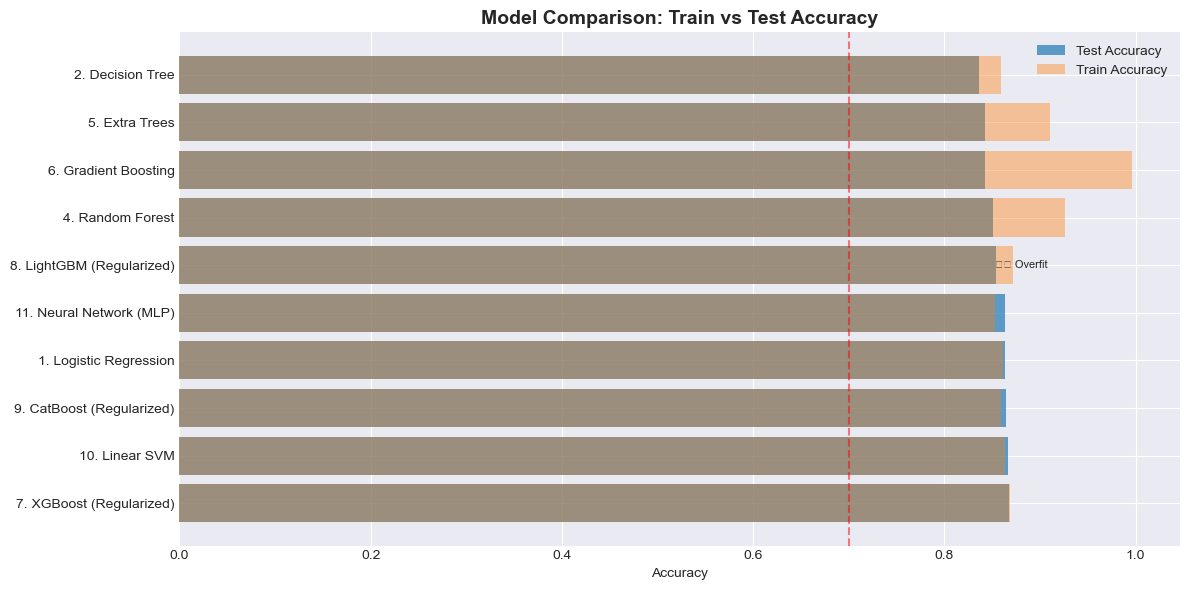

✅ Saved: models/model_comparison.png


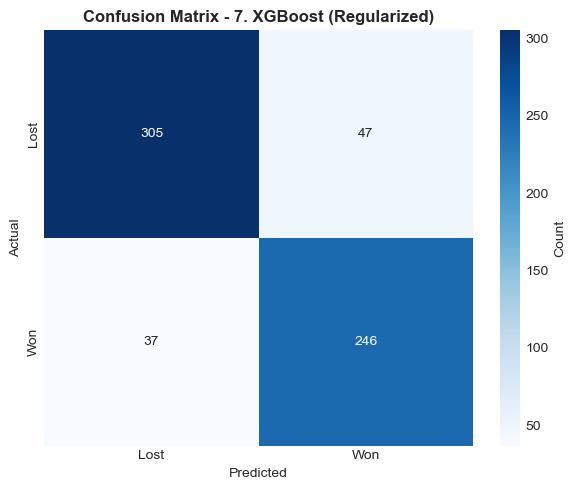

✅ Saved: models/confusion_matrix.png


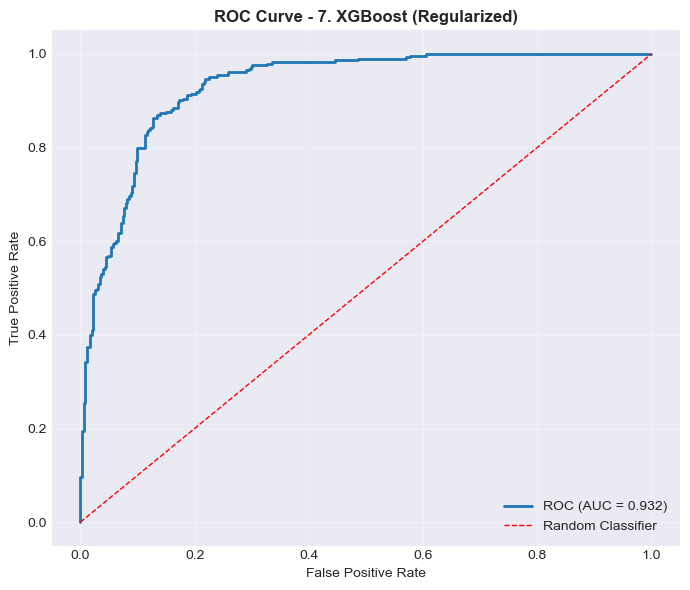

✅ Saved: models/roc_curve.png


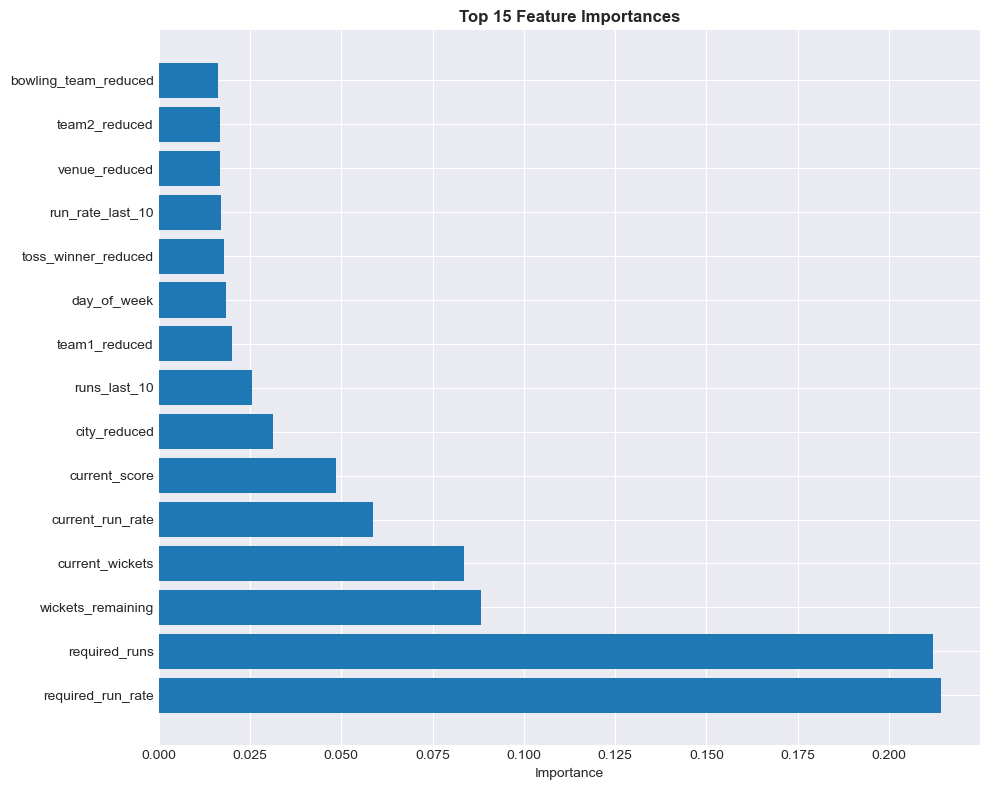

✅ Saved: models/feature_importance.png

✅ All visualizations created in models/ directory


In [18]:
print("\n" + "=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)

plt.style.use('seaborn-v0_8-darkgrid')

# -------------------------------
# 1️⃣ Model comparison bar chart
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

models_plot = comparison.head(10)
x = range(len(models_plot))

ax.barh(x, models_plot['Test_Acc'], alpha=0.7, label='Test Accuracy')
ax.barh(x, models_plot['Train_Acc'], alpha=0.4, label='Train Accuracy')

ax.set_yticks(x)
ax.set_yticklabels(models_plot['Model'])
ax.set_xlabel('Accuracy')
ax.set_title('Model Comparison: Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax.legend()
ax.axvline(x=0.70, color='red', linestyle='--', alpha=0.5)

for i, row in models_plot.iterrows():
    if row['Overfit'] > 0.08:
        ax.text(row['Test_Acc'] + 0.01, i, '⚠️ Overfit', fontsize=8, va='center')

plt.tight_layout()
plt.show()
plt.savefig('models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: models/model_comparison.png")


# -------------------------------
# 2️⃣ Confusion matrix
# -------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Lost', 'Won'],
    yticklabels=['Lost', 'Won'],
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('models/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: models/confusion_matrix.png")


# -------------------------------
# 3️⃣ ROC Curve
# -------------------------------
if results[best_model_name]['test_auc'] is not None:
    y_proba_best = results[best_model_name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)

    fig, ax = plt.subplots(figsize=(7, 6))

    ax.plot(
        fpr,
        tpr,
        linewidth=2,
        label=f'ROC (AUC = {results[best_model_name]["test_auc"]:.3f})'
    )
    ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {best_model_name}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.savefig('models/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Saved: models/roc_curve.png")


# -------------------------------
# 4️⃣ Feature importance
# -------------------------------
if hasattr(best_model_obj, 'feature_importances_'):
    fig, ax = plt.subplots(figsize=(10, 8))

    top_features = feature_imp.head(15)

    ax.barh(range(len(top_features)), top_features['importance'])
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance')
    ax.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.savefig('models/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Saved: models/feature_importance.png")

print("\n✅ All visualizations created in models/ directory")


In [19]:
print("\n" + "=" * 80)
print("RECOMMENDATIONS & NEXT STEPS")
print("=" * 80)
print(f"\n💡 Based on results:")

#Get overall performance
avg_test_acc = comparison['Test_Acc'].mean()
avg_overfit = comparison['Overfit'].mean()
if avg_test_acc < 0.60:
    print(f"\n⚠️  OVERALL PERFORMANCE IS LOW (Avg: {avg_test_acc:.2f})")
    print(f"\n   Recommended actions:")
    print(f"   1. ✅ Check data quality in Notebook 1")
    print(f"   2. ✅ Add more features (venue stats, team history)")
    print(f"   3. ✅ Get more data (more matches)")
    print(f"   4. ✅ Verify no data leakage")
elif avg_test_acc < 0.70:
    print(f"\n👍 PERFORMANCE IS DECENT (Avg: {avg_test_acc:.2f})")
    print(f"\n   To improve further:")
    print(f"   1. ✅ Hyperparameter tuning on top 3 models")
    print(f"   2. ✅ Feature engineering (interaction terms)")
    print(f"   3. ✅ Ensemble top 3 models")
else:
    print(f"\n✅ PERFORMANCE IS GOOD (Avg: {avg_test_acc:.2f})")
    print(f"\n   You're production-ready!")
    print(f"   Optional improvements:")
    print(f"   1. ✅ Fine-tune best model")
    print(f"   2. ✅ Create ensemble")
    print(f"   3. ✅ Deploy to Streamlit")
if avg_overfit > 0.08:
    print(f"\n⚠️  OVERFITTING DETECTED (Avg gap: {avg_overfit:.3f})")
    print(f"\n   Solutions:")
    print(f"   1. ✅ Reduce model complexity (lower max_depth)")
    print(f"   2. ✅ Add regularization (higher reg_alpha/lambda)")
    print(f"   3. ✅ Get more training data")
    print(f"   4. ✅ Use simpler models (Random Forest instead of XGBoost)")
    print(f"\n🎯 Top 3 models for deployment:")
for idx, row in comparison.head(3).iterrows():
    print(f"   {idx+1}. {row['Model']}: Test={row['Test_Acc']:.3f}, Overfit={row['Overfit']:.3f}")
print(f"\n" + "=" * 80)
print(f"✅ MODEL TRAINING COMPLETE")
print(f"=" * 80)
print(f"\n📁 Results saved in 'models/' directory:")
print(f"   - model_comparison.csv")
print(f"   - Top 3 model .pkl files")
print(f"   - Visualizations (PNG files)")
print(f"   - Feature importance")
print(f"\n🚀 Ready for deployment!")


RECOMMENDATIONS & NEXT STEPS

💡 Based on results:

✅ PERFORMANCE IS GOOD (Avg: 0.84)

   You're production-ready!
   Optional improvements:
   1. ✅ Fine-tune best model
   2. ✅ Create ensemble
   3. ✅ Deploy to Streamlit
   7. 7. XGBoost (Regularized): Test=0.868, Overfit=0.000
   10. 10. Linear SVM: Test=0.866, Overfit=-0.002
   9. 9. CatBoost (Regularized): Test=0.865, Overfit=-0.005

✅ MODEL TRAINING COMPLETE

📁 Results saved in 'models/' directory:
   - model_comparison.csv
   - Top 3 model .pkl files
   - Visualizations (PNG files)
   - Feature importance

🚀 Ready for deployment!


In [20]:
print("=" * 80)
print("ENSEMBLE MODEL (SOFT VOTING)")
print("=" * 80)

# Select top-performing models (adjust names if needed)
ensemble_models = [
    "7. XGBoost (Regularized)",
    "8. LightGBM (Regularized)",
    "9. CatBoost (Regularized)"
]

# Filter only models that actually ran
ensemble_models = [m for m in ensemble_models if m in results]

assert len(ensemble_models) >= 2, "❌ Need at least 2 models for ensemble"

print(f"\n📦 Models used in ensemble:")
for m in ensemble_models:
    print(f"   • {m}")

# Collect probabilities
probas = np.column_stack([
    results[m]['probabilities'] for m in ensemble_models
])

# Optional: weighted ensemble (based on validation performance)
weights = np.array([
    results[m]['val_acc'] for m in ensemble_models
])
weights = weights / weights.sum()  # normalize

print(f"\n⚖️ Ensemble weights:")
for m, w in zip(ensemble_models, weights):
    print(f"   {m}: {w:.2f}")

# Final ensemble probabilities
ensemble_proba = np.average(probas, axis=1, weights=weights)
ensemble_preds = (ensemble_proba >= 0.5).astype(int)

# Evaluate ensemble
ensemble_acc = accuracy_score(y_test, ensemble_preds)
ensemble_f1 = f1_score(y_test, ensemble_preds)
ensemble_auc = roc_auc_score(y_test, ensemble_proba)

print(f"\n📊 ENSEMBLE PERFORMANCE (TEST):")
print(f"   Accuracy: {ensemble_acc:.4f}")
print(f"   F1-score: {ensemble_f1:.4f}")
print(f"   AUC-ROC:  {ensemble_auc:.4f}")

print("\n🏆 Ensemble ready for deployment!")


ENSEMBLE MODEL (SOFT VOTING)

📦 Models used in ensemble:
   • 7. XGBoost (Regularized)
   • 8. LightGBM (Regularized)
   • 9. CatBoost (Regularized)

⚖️ Ensemble weights:
   7. XGBoost (Regularized): 0.33
   8. LightGBM (Regularized): 0.33
   9. CatBoost (Regularized): 0.33

📊 ENSEMBLE PERFORMANCE (TEST):
   Accuracy: 0.8583
   F1-score: 0.8454
   AUC-ROC:  0.9324

🏆 Ensemble ready for deployment!
